In [1]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch
from typing import Any, Callable, Dict, List, Optional, Union

import matplotlib.pyplot as plt
import numpy as np

torch.set_grad_enabled(False)

In [2]:
model_id = "stabilityai/stable-diffusion-2-base"

# Use the Euler scheduler here instead
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

In [3]:
def linear_interpolate(start, end, num_frames):
    if len(start.shape) == 2: start = torch.unsqueeze(start, dim=0)
    if len(end.shape) == 2: end = torch.unsqueeze(end, dim=0)

    steps = np.linspace(0., 1., num_frames+2)[1:-1]
    prompt_embeddings_interp = torch.zeros_like(start)
    
    for step in steps:
        prompt_embeddings_interp = torch.cat((prompt_embeddings_interp,(1 - step)*start + step*end), dim=0)
        prompt_embeddings_interp = prompt_embeddings_interp[1:,:,:]

    return prompt_embeddings_interp

In [4]:
start_prompt = "man opening a car door"
end_prompt = "man closing a car door"

height: Optional[int] = None
width: Optional[int] = None
num_inference_steps: int = 50
guidance_scale: float = 7.5
negative_prompt: Optional[Union[str, List[str]]] = None
num_images_per_prompt: Optional[int] = 1
eta: float = 0.0
generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None
latents: Optional[torch.FloatTensor] = None
prompt_embeds: Optional[torch.FloatTensor] = None
negative_prompt_embeds: Optional[torch.FloatTensor] = None
output_type: Optional[str] = "pil"
return_dict: bool = True
callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None
callback_steps: int = 1
cross_attention_kwargs: Optional[Dict[str, Any]] = None
guidance_rescale: float = 0.0

self = pipe

height = height or self.unet.config.sample_size * self.vae_scale_factor
width = width or self.unet.config.sample_size * self.vae_scale_factor

# 1. Check inputs. Raise error if not correct
# self.check_inputs(
#     prompt, height, width, callback_steps, negative_prompt, prompt_embeds, negative_prompt_embeds
# )

# 2. Define call parameters
# if prompt is not None and isinstance(prompt, str):
#     batch_size = 1
# elif prompt is not None and isinstance(prompt, list):
#     batch_size = len(prompt)
# else:
#     batch_size = prompt_embeds.shape[0]

batch_size = 1

device = self._execution_device
# here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
# of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
# corresponds to doing no classifier free guidance.
do_classifier_free_guidance = guidance_scale > 1.0

def get_prompts(self, 
                cross_attention_kwargs, 
                prompt, 
                device, 
                num_images_per_prompt,
                prompt_embeds,
                negative_prompt_embeds):
    # 3. Encode input prompt
    text_encoder_lora_scale = (
        cross_attention_kwargs.get("scale", None) if cross_attention_kwargs is not None else None
    )
    prompt_embeds = self._encode_prompt(
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        None,
        prompt_embeds=prompt_embeds,
        negative_prompt_embeds=negative_prompt_embeds,
        lora_scale=text_encoder_lora_scale,
    )
    
    return prompt_embeds

In [5]:
negative_prompt, start_prompt = get_prompts(pipe,
                           cross_attention_kwargs,
                           start_prompt,
                           device,
                           num_images_per_prompt,
                           None,
                           None)

n2, end_prompt = get_prompts(pipe,
                           cross_attention_kwargs,
                           end_prompt,
                           device,
                           num_images_per_prompt,
                           None,
                           None)

In [6]:
prompt_lists = [torch.lerp(start_prompt, end_prompt, weight) for weight in np.linspace(0, 1, 5)]

In [7]:
def generate_images(self,
                   pos_prompt,
                   negative_prompt,
                   batch_size,
                   num_images_per_prompt,
                   height,
                   width,
                   device,
                   generator,
                   latents,
                   eta,
                   num_inference_steps,
                   do_classifier_free_guidance,
                   guidance_rescale,
                   output_type):
    
    self.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = self.scheduler.timesteps

    # 5. Prepare latent variables
    num_channels_latents = self.unet.config.in_channels
    latents = self.prepare_latents(
        batch_size * num_images_per_prompt,
        num_channels_latents,
        height,
        width,
        pos_prompt.dtype,
        device,
        generator,
        latents,
    )
    
    # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
    extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

    prompt_embeds = torch.vstack((negative_prompt[None, :], pos_prompt[None, :]))
    # 7. Denoising loop
    num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
    with self.progress_bar(total=num_inference_steps) as progress_bar:
        for i, t in enumerate(timesteps):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                cross_attention_kwargs=cross_attention_kwargs,
                return_dict=False,
            )[0]

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            if do_classifier_free_guidance and guidance_rescale > 0.0:
                # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=guidance_rescale)

            # compu/te the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
            
            # call the callback, if provided
            if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                progress_bar.update()
                if callback is not None and i % callback_steps == 0:
                    callback(i, t, latents)

    if not output_type == "latent":
        image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
        image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
    else:
        image = latents
        has_nsfw_concept = None

    if has_nsfw_concept is None:
        do_denormalize = [True] * image.shape[0]
    else:
        do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]

    image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)
    
    return image

In [8]:
image_lists = []

for pos_prompt in prompt_lists:
    # 4. Prepare timesteps
    image = generate_images(pipe,
                   pos_prompt,
                   negative_prompt,
                   batch_size,
                   num_images_per_prompt,
                   height,
                   width,
                   device,
                   generator,
                   latents,
                   eta,
                   num_inference_steps,
                   do_classifier_free_guidance,
                   guidance_rescale,
                   output_type)[0]
    
    image_lists.append(image)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

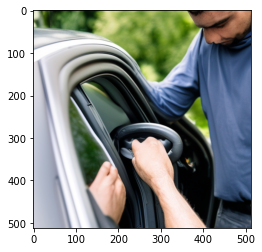

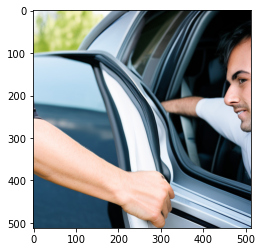

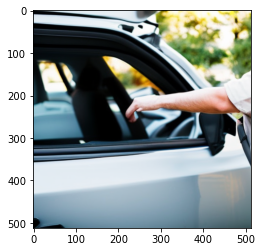

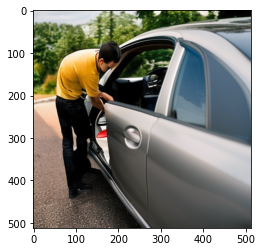

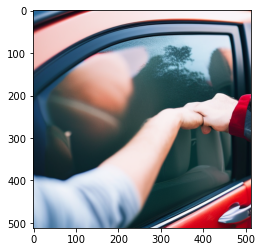

In [9]:
for image in image_lists:
    plt.figure()
    plt.imshow(image)

In [10]:
# Offload last model to CPU
if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
    self.final_offload_hook.offload()